# Toka_LITE: 0D Tokamak Parameter Scan

0D parameter study for a small, non-neutronic tokamak.
The model computes plasma current, density, TF coil current and beta
over a grid in aspect ratio and toroidal fild.


## Imports

In [40]:
import math
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# constants
mu0 = 4.0 * math.pi * 1e-7
kB = 1.380649e-23
eV = 1.602176634e-19

## Geometry and Plasma

In [41]:
@dataclass
class Shape:
    R: float      # major radius [m]
    a: float      # minor radius [m]
    kappa: float  # elongation
    delta: float  # triangularity

    @property
    def aspect_ratio(self) -> float:
        return self.R / self.a


def fq_PROCESS(shape: Shape) -> float:
    """
    Shaping factor in the Ip–q95–Bt relation.
    """
    A = shape.aspect_ratio
    k = shape.kappa
    d = shape.delta

    num = 1.17 - 0.65 * A * A
    den = 1.0 - A * A
    # only protect against den ~ 0, not den < 0
    if abs(den) < 1e-6:
        den = 1e-6

    f1 = num / den
    f2 = 0.5 * (1.0 + k * k)
    f3 = 1.0 + 2.0 * d * d - 1.2 * d * d * d
    return f1 * f2 * f3

def Ip_from_q95_PROCESS(Bt: float, q95: float, shape: Shape) -> float:
    """
    Plasma current Ip in MA.
    Bt [T], R,a [m].
    """
    fq = fq_PROCESS(shape)
    return 5.0 * shape.a * shape.a * Bt / (q95 * shape.R * fq)


def greenwald_density(Ip_MA: float, a: float, f_G: float = 0.4):
    """
    Greenwald limit nG and operating ne, in m^-3.
    """
    nG = 1.0e20 * Ip_MA / (math.pi * a * a)
    ne = f_G * nG
    return nG, ne


def thermal_beta(Bt: float, ne: float, Te_eV: float, Ti_eV: float) -> float:
    """
    Thermal beta using scalar pressure p = ne k_B (Te + Ti).
    """
    # Te, Ti in eV -> J
    Te_J = Te_eV * eV
    Ti_J = Ti_eV * eV
    p = ne * (Te_J + Ti_J)
    return 2.0 * mu0 * p / (Bt * Bt)

## TF Coil Model

In [42]:
@dataclass
class TFCoils:
    N_tf: int          # number of TF coils
    N_turn: int        # turns per coil
    I_max_coil: float  # limit per coil [A]

    def coil_current(self, Bt: float, R0: float) -> float:
        """
        Required coil current [A] per coil for Bt at radius R0.
        """
        Itot = 2.0 * math.pi * R0 * Bt / mu0
        return Itot / (self.N_tf * self.N_turn)

    def feasible(self, Bt: float, R0: float) -> bool:
        return self.coil_current(Bt, R0) <= self.I_max_coil

## Scan feasible design space

In [43]:
def scan_A_Bt_grid(
    A_min: float,
    A_max: float,
    Bt_min: float,
    Bt_max: float,
    n_A: int,
    n_Bt: int,
    a: float,
    kappa: float,
    delta: float,
    q95: float,
    f_G: float,
    Te_eV: float,
    Ti_eV: float,
    tf: TFCoils,
):
    """
    Scan over (aspect ratio A, toroidal field Bt).
    Returns dict of 2D grids.
    """

    A_vals = np.linspace(A_min, A_max, n_A)
    Bt_vals = np.linspace(Bt_min, Bt_max, n_Bt)

    A_grid, Bt_grid = np.meshgrid(A_vals, Bt_vals, indexing="ij")

    Ip_grid = np.zeros_like(A_grid)       # MA
    ne_grid = np.zeros_like(A_grid)       # m^-3
    Icoil_grid = np.zeros_like(A_grid)    # A
    beta_grid = np.zeros_like(A_grid)     # scalar
    R_grid = np.zeros_like(A_grid)        # m
    feasible_mask = np.ones_like(A_grid, dtype=bool)

    for i in range(n_A):
        for j in range(n_Bt):
            A = A_grid[i, j]
            Bt = Bt_grid[i, j]

            R = A * a
            shape = Shape(R=R, a=a, kappa=kappa, delta=delta)

            Ip_MA = Ip_from_q95_PROCESS(Bt, q95, shape)
            _, ne = greenwald_density(Ip_MA, a, f_G)
            beta = thermal_beta(Bt, ne, Te_eV, Ti_eV)

            Icoil = tf.coil_current(Bt, R)
            feasible = tf.feasible(Bt, R)

            Ip_grid[i, j] = Ip_MA
            ne_grid[i, j] = ne
            Icoil_grid[i, j] = Icoil
            beta_grid[i, j] = beta
            R_grid[i, j] = R
            feasible_mask[i, j] = feasible

    return {
        "A": A_grid,
        "Bt": Bt_grid,
        "Ip_MA": Ip_grid,
        "ne": ne_grid,
        "Icoil": Icoil_grid,
        "beta": beta_grid,
        "R": R_grid,
        "feasible": feasible_mask,
    }

## Plots

In [44]:
def plot_surface(
    X,
    Y,
    Z,
    xlabel: str,
    ylabel: str,
    zlabel: str,
    title: str,
    cmap: str = "viridis",
    elev: float = 28,
    azim: float = -45,
    figsize=(4.2, 3.4),
    dpi=220,
):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, projection="3d")

    # Surface
    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cmap,
        linewidth=0,
        antialiased=True,
        shade=True
    )

    # Tight academic labels
    ax.set_xlabel(xlabel, fontsize=7, labelpad=2)
    ax.set_ylabel(ylabel, fontsize=7, labelpad=2)
    ax.set_zlabel(zlabel, fontsize=7, labelpad=4)
    ax.set_title(title, fontsize=8, pad=6)

    # Small ticks and scientific notation
    ax.tick_params(axis="both", which="major", labelsize=6, pad=1)
    ax.tick_params(axis="z", labelsize=6, pad=2)

    # Scientific notation if numbers are large/small
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2g'))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2g'))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.2g'))

    # Colorbar with disciplined formatting
    cbar = fig.colorbar(surf, shrink=0.63, pad=0.05)
    cbar.ax.tick_params(labelsize=6)
    cbar.formatter = plt.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((-2, 2))
    cbar.update_ticks()
    cbar.set_label(zlabel, fontsize=7, labelpad=3)

    # Camera
    ax.view_init(elev=elev, azim=azim)

    # Layout
    plt.tight_layout(pad=0.8)

    return fig, ax


## Baseline configuration

Minor radius, shaping, safety factor, density fraction, temperature,
and TF coil layout for a small university-scale tokamak.


In [45]:
# plasma parameters
a = 0.25       # minor radius [m]
kappa = 1.6    # elongation
delta = 0.0    # triangularity
q95 = 4.0
f_G = 0.4      # Greenwald fraction
Te_eV = 100.0
Ti_eV = 50.0

# TF coil configuration
tf = TFCoils(
    N_tf=12,
    N_turn=4,
    I_max_coil=15_000.0,  # A
)

print("Toka_LITE baseline configuration set.")

Toka_LITE baseline configuration set.


## (A, Bt) scan

Scan aspect ratio and toroidal field for the chosen configuration.


In [46]:
grids = scan_A_Bt_grid(
    A_min=1.5,
    A_max=3.0,
    Bt_min=0.25,
    Bt_max=0.75,
    n_A=60,
    n_Bt=60,
    a=a,
    kappa=kappa,
    delta=delta,
    q95=q95,
    f_G=f_G,
    Te_eV=Te_eV,
    Ti_eV=Ti_eV,
    tf=tf,
)

print("Parameter scan finished.")

Parameter scan finished.


## Extract fields

Convert to convenient units and apply feasibility mask based on TF coil current limit.


In [47]:
A = grids["A"]
Bt = grids["Bt"]
Ip_kA = grids["Ip_MA"] * 1e3
ne = grids["ne"]
Icoil_kA = grids["Icoil"] * 1e-3
beta = grids["beta"]
mask = grids["feasible"]

Ip_kA = np.where(mask, Ip_kA, np.nan)
ne = np.where(mask, ne, np.nan)
Icoil_kA = np.where(mask, Icoil_kA, np.nan)
beta = np.where(mask, beta, np.nan)

print("Arrays ready for plotting.")


Arrays ready for plotting.


## 3D surface plots

Ip, ne, TF coil current and thermal beta surfaces
as functions of aspect ratio and toroidal field.


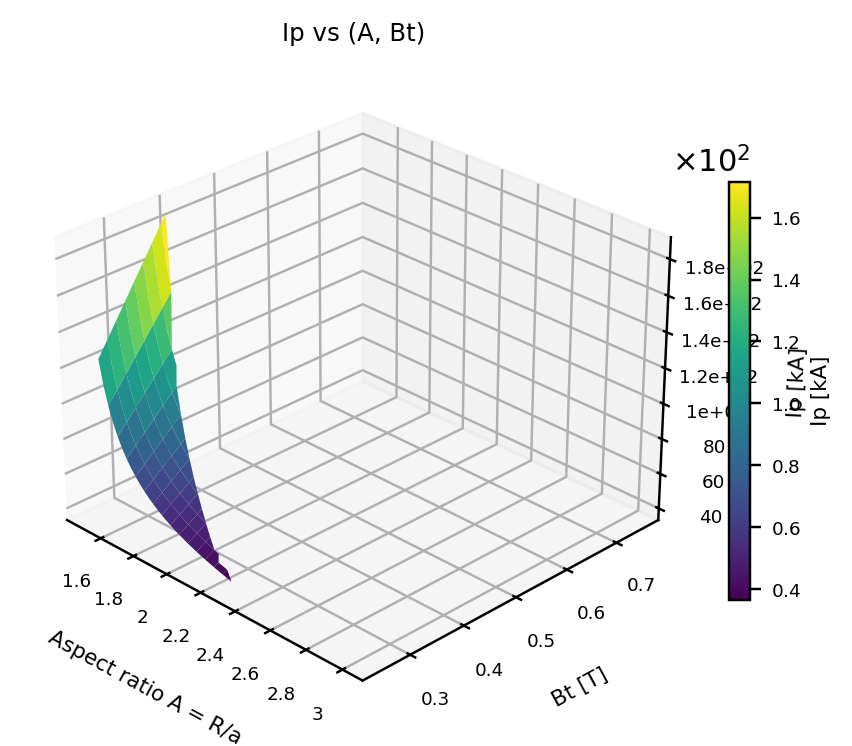

In [48]:
plot_surface(
    A, Bt, Ip_kA,
    xlabel="Aspect ratio A = R/a",
    ylabel="Bt [T]",
    zlabel="Ip [kA]",
    title="Ip vs (A, Bt)",
)
plt.show()

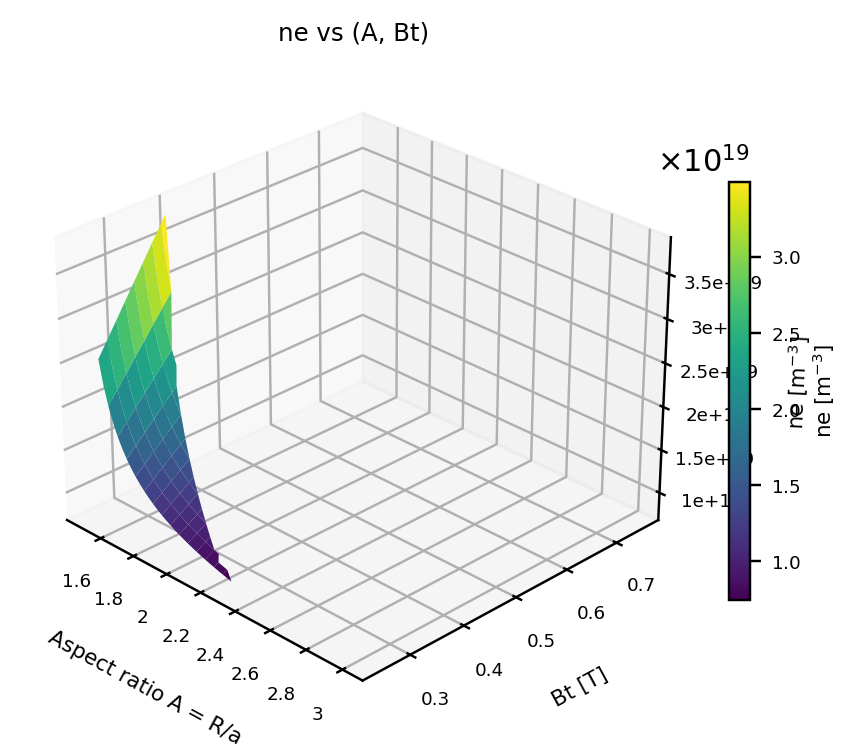

In [49]:

plot_surface(
    A, Bt, ne,
    xlabel="Aspect ratio A = R/a",
    ylabel="Bt [T]",
    zlabel="ne [m$^{-3}$]",
    title="ne vs (A, Bt)",
)

plt.show()

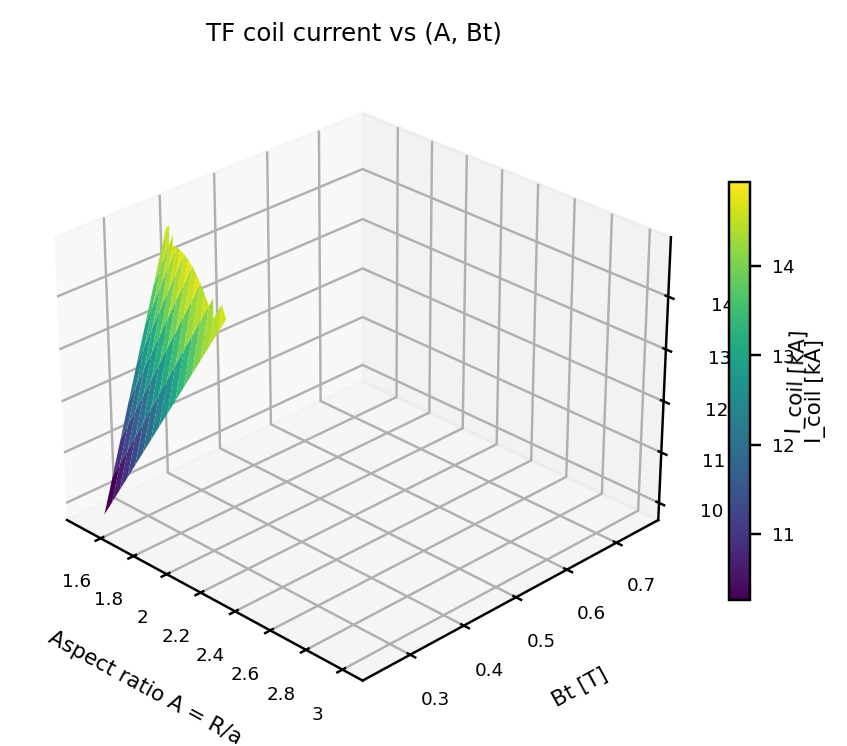

In [50]:
plot_surface(
    A, Bt, Icoil_kA,
    xlabel="Aspect ratio A = R/a",
    ylabel="Bt [T]",
    zlabel="I_coil [kA]",
    title="TF coil current vs (A, Bt)",
)

plt.show()

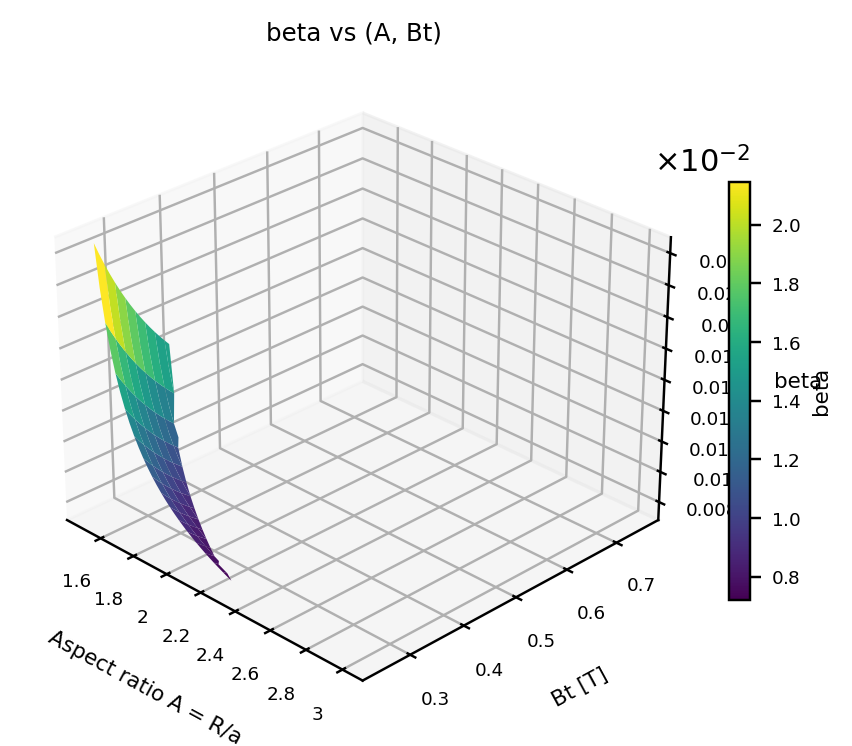

In [51]:
plot_surface(
    A, Bt, beta,
    xlabel="Aspect ratio A = R/a",
    ylabel="Bt [T]",
    zlabel="beta",
    title="beta vs (A, Bt)",
)

plt.show()